In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs

**Optimization datafame**

In [3]:
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Function to plot continuous variables distribution**

In [16]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

**Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target**

In [22]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

**credit_card_balance.csv**



*   Bảng dữ liệu về số dư thẻ tín dụng trước đó mà người vay đăng ký với Home Credit
*   Mỗi khoản vay trong dataset có thể có 0,1,2 hoặc nhiều khoản vay trước đó ở Home Credit
*   Dữ liệu mỗi tháng của mỗi khoản tín dụng mà người vay đăng ký với Home Credit trước đó ứng với một dòng trong bảng




|STT| Feature     | Ý nghĩa |
|---| ----------- | ----------- |
|1 | **SK_ID_PREV**  | ID của khoản vay trước đó ở Home Credit liên quan đến khoản vay trong dataset|
|2| **SK_ID_CURR**  | ID của khoản vay trong dataset        |
|3| **MONTHS_BALANCE** | Số tháng mà thẻ tín dụng dư tính đến ngày nộp đơn (-1 hay 0 nghĩa là tháng gân nhất)|
|4|**AMT_BALANCE**| Số dư trung bình mà người vay thường có trong tài khoản tín dụng đăng ký cho khoản vay trước đó |
|5|**AMT_CREDIT_LIMIT_ACTUAL**|Hạn mức thẻ tín dụng trong tháng của khoản vay trước đó|
|6|**AMT_DRAWINGS_ATM_CURRENT**|Số tiền rút ***tại ATM*** trong tháng của khoản vay trước đó|
|7|**CNT_DRAWINGS_ATM_CURRENT**|Số lần rút tiền ***tại ATM*** trong tháng khi đang trong khoản vay trước đó|
|8|**AMT_DRAWINGS_CURRENT**|Số tiền rút trong tháng của khoản vay trước đó|
|9|**CNT_DRAWINGS_CURRENT**|Số lần rút tiền trong tháng trong tháng khi đang trong khoản vay trước đó|
|10|**AMT_DRAWINGS_OTHER_CURRENT**|Số tiền rút  ***khác*** trong tháng của khoản vay trước đó|
|11|**CNT_DRAWINGS_OTHER_CURRENT**|Số lần rút tiền ***khác*** trong tháng trong tháng khi đang trong khoản vay trước đó|
|12|**AMT_DRAWINGS_POS_CURRENT**|Số tiền rút hoặc mua hàng (qua máy quẹt thẻ) trong tháng của khoản vay trước đó|
|13|**CNT_DRAWINGS_POS_CURRENT**|Số lần rút tiền hoặc mua hàng (qua máy quẹt thẻ) trong tháng của khoản vay trước đó|
|14|**AMT_INST_MIN_REGULARITY**|Số tiền khả góp tối thiểu trong tháng của khoản vay trước đó|
|15|**AMT_PAYMENT_CURRENT**|Khách hàng đã trả bao nhiêu trong tháng cho khoản vay trước đó|
|16|**AMT_PAYMENT_TOTAL_CURRENT**|Khách hàng đã trả tổng cộng bao nhiêu trong tháng cho khoản vay trước đó|
|17|**AMT_RECEIVABLE_PRINCIPAL**|Số tiền phải thu đối với tiền gốc của khoản vay trước đó|
|18|**AMT_RECIVABLE**|Số tiền phải thu đối với khoản vay trước đó|
|19|**AMT_TOTAL_RECEIVABLE**|Tổng số tiền phải thu đối với khoản vay trước đó|
|20|**CNT_INSTALMENT_MATURE_CUM**|Số lần trả góp của khoản vay trước đó|
|21|**NAME_CONTRACT_STATUS**|Trạng thái hợp đồng của khoản vay trước đó|
|22|**SK_DPD**|Số ngày quá hạn trong tháng đối với khoản vay trước đó|
|23|**SK_DPD_DEF**|Số ngày quá hạn trong tháng chấp nhận được của khoản vay trước đó|





In [4]:
import gdown
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
credit_card_balance = reduce_memory_usage(pd.read_csv('/content/drive/MyDrive/Colab/credit_card_balance.csv'))
print('Number of data points : ', credit_card_balance.shape[0])
print('Number of features : ', credit_card_balance.shape[1])
credit_card_balance.head(10)

Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Number of data points :  3840312
Number of features :  23


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.500000,0.0,877.500000,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.000000,0.0,0.000000,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.000000,0.0,0.000000,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.000000,0.0,0.000000,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.000000,0.0,11547.000000,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0
5,2646502,380010,-7,82903.812500,270000,0.0,0.000000,0.0,0.000000,4449.104980,...,82773.312500,82773.312500,0.0,0,0.0,0.0,2.0,Active,7,0
6,1079071,171320,-6,353451.656250,585000,67500.0,67500.000000,0.0,0.000000,14684.174805,...,351881.156250,351881.156250,1.0,1,0.0,0.0,6.0,Active,0,0
7,2095912,118650,-7,47962.125000,45000,45000.0,45000.000000,0.0,0.000000,0.000000,...,47962.125000,47962.125000,1.0,1,0.0,0.0,51.0,Active,0,0
8,2181852,367360,-4,291543.062500,292500,90000.0,289339.437500,0.0,199339.421875,130.500000,...,286831.562500,286831.562500,3.0,8,0.0,5.0,3.0,Active,0,0
9,1235299,203885,-5,201261.187500,225000,76500.0,111026.703125,0.0,34526.699219,6338.339844,...,197224.687500,197224.687500,3.0,9,0.0,6.0,38.0,Active,0,0


In [7]:
credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int32  
 1   SK_ID_CURR                  int32  
 2   MONTHS_BALANCE              int8   
 3   AMT_BALANCE                 float32
 4   AMT_CREDIT_LIMIT_ACTUAL     int32  
 5   AMT_DRAWINGS_ATM_CURRENT    float32
 6   AMT_DRAWINGS_CURRENT        float32
 7   AMT_DRAWINGS_OTHER_CURRENT  float32
 8   AMT_DRAWINGS_POS_CURRENT    float32
 9   AMT_INST_MIN_REGULARITY     float32
 10  AMT_PAYMENT_CURRENT         float32
 11  AMT_PAYMENT_TOTAL_CURRENT   float32
 12  AMT_RECEIVABLE_PRINCIPAL    float32
 13  AMT_RECIVABLE               float32
 14  AMT_TOTAL_RECEIVABLE        float32
 15  CNT_DRAWINGS_ATM_CURRENT    float16
 16  CNT_DRAWINGS_CURRENT        int16  
 17  CNT_DRAWINGS_OTHER_CURRENT  float16
 18  CNT_DRAWINGS_POS_CURRENT    float16
 19  CNT_INSTALMENT_MATURE

In [9]:
credit_card_balance.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,3840312.0,1.904504e+06,536469.470563,1.000018e+06,1.434385e+06,1.897122e+06,2.369328e+06,2843496.000
SK_ID_CURR,3840312.0,2.783242e+05,102704.475133,1.000060e+05,1.895170e+05,2.783960e+05,3.675800e+05,456250.000
MONTHS_BALANCE,3840312.0,-3.452192e+01,26.667751,-9.600000e+01,-5.500000e+01,-2.800000e+01,-1.100000e+01,-1.000
AMT_BALANCE,3840312.0,5.830016e+04,106307.031250,-4.202502e+05,0.000000e+00,0.000000e+00,8.904669e+04,1505902.125
AMT_CREDIT_LIMIT_ACTUAL,3840312.0,1.538080e+05,165145.699525,0.000000e+00,4.500000e+04,1.125000e+05,1.800000e+05,1350000.000
AMT_DRAWINGS_ATM_CURRENT,3090496.0,5.961323e+03,28225.687500,-6.827310e+03,0.000000e+00,0.000000e+00,0.000000e+00,2115000.000
AMT_DRAWINGS_CURRENT,3840312.0,7.433390e+03,33846.078125,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,2287098.250
AMT_DRAWINGS_OTHER_CURRENT,3090496.0,2.881696e+02,8201.989258,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1529847.000
AMT_DRAWINGS_POS_CURRENT,3090496.0,2.968804e+03,20796.886719,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2239274.250
AMT_INST_MIN_REGULARITY,3535076.0,3.540206e+03,5600.154297,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,202882.000


In [11]:
credit_card_balance.nunique()

SK_ID_PREV                     104307
SK_ID_CURR                     103558
MONTHS_BALANCE                     96
AMT_BALANCE                   1347882
AMT_CREDIT_LIMIT_ACTUAL           181
AMT_DRAWINGS_ATM_CURRENT         2267
AMT_DRAWINGS_CURRENT           187005
AMT_DRAWINGS_OTHER_CURRENT       1832
AMT_DRAWINGS_POS_CURRENT       168748
AMT_INST_MIN_REGULARITY        312266
AMT_PAYMENT_CURRENT            163209
AMT_PAYMENT_TOTAL_CURRENT      182957
AMT_RECEIVABLE_PRINCIPAL      1195807
AMT_RECIVABLE                 1338857
AMT_TOTAL_RECEIVABLE          1338987
CNT_DRAWINGS_ATM_CURRENT           44
CNT_DRAWINGS_CURRENT              129
CNT_DRAWINGS_OTHER_CURRENT         11
CNT_DRAWINGS_POS_CURRENT          133
CNT_INSTALMENT_MATURE_CUM         121
NAME_CONTRACT_STATUS                7
SK_DPD                            917
SK_DPD_DEF                        378
dtype: int64

In [13]:
def missing_data(df):
   total = df.isnull().sum().sort_values(ascending = False)
   percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
   return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [14]:
missing_data(credit_card_balance)

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


In [34]:
#encode categorical for calculate var
scale_mapper = {"Active":1, "Approved":2, "Completed":3, "Refused":4, "Sent proposal":5, "Signed":6, "Demand":7}
credit_card_balance['NAME_CONTRACT_STATUS'] = credit_card_balance['NAME_CONTRACT_STATUS'].replace(scale_mapper)

(3840312, 22) (3840312,)


In [37]:
credit_card_balance.var()

SK_ID_PREV                    2.877995e+11
SK_ID_CURR                    1.054821e+10
MONTHS_BALANCE                7.111689e+02
AMT_BALANCE                   1.130118e+10
AMT_CREDIT_LIMIT_ACTUAL       2.727310e+10
AMT_DRAWINGS_ATM_CURRENT      7.966895e+08
AMT_DRAWINGS_CURRENT          1.145557e+09
AMT_DRAWINGS_OTHER_CURRENT    6.727263e+07
AMT_DRAWINGS_POS_CURRENT      4.325105e+08
AMT_INST_MIN_REGULARITY       3.136173e+07
AMT_PAYMENT_CURRENT           1.301628e+09
AMT_PAYMENT_TOTAL_CURRENT     1.024383e+09
AMT_RECEIVABLE_PRINCIPAL      1.051314e+10
AMT_RECIVABLE                 1.122866e+10
AMT_TOTAL_RECEIVABLE          1.123002e+10
CNT_DRAWINGS_ATM_CURRENT      0.000000e+00
CNT_DRAWINGS_CURRENT          1.017831e+01
CNT_DRAWINGS_OTHER_CURRENT    0.000000e+00
CNT_DRAWINGS_POS_CURRENT      0.000000e+00
CNT_INSTALMENT_MATURE_CUM     0.000000e+00
NAME_CONTRACT_STATUS          2.141467e-01
SK_DPD                        9.509312e+03
SK_DPD_DEF                    4.613574e+02
dtype: floa

**Merging the TARGETS from application_train to credit_card_balance table.**

In [15]:
print("-"*100)
application_train = reduce_memory_usage(pd.read_csv('/content/drive/MyDrive/Colab/application_train.csv'))
print("Merging TARGET with credit_card_balance Table")
credit_card_balance_merged = application_train.iloc[:,:2].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Merging TARGET with credit_card_balance Table
----------------------------------------------------------------------------------------------------


**Correlation Matrix of Features**

----------------------------------------------------------------------------------------------------


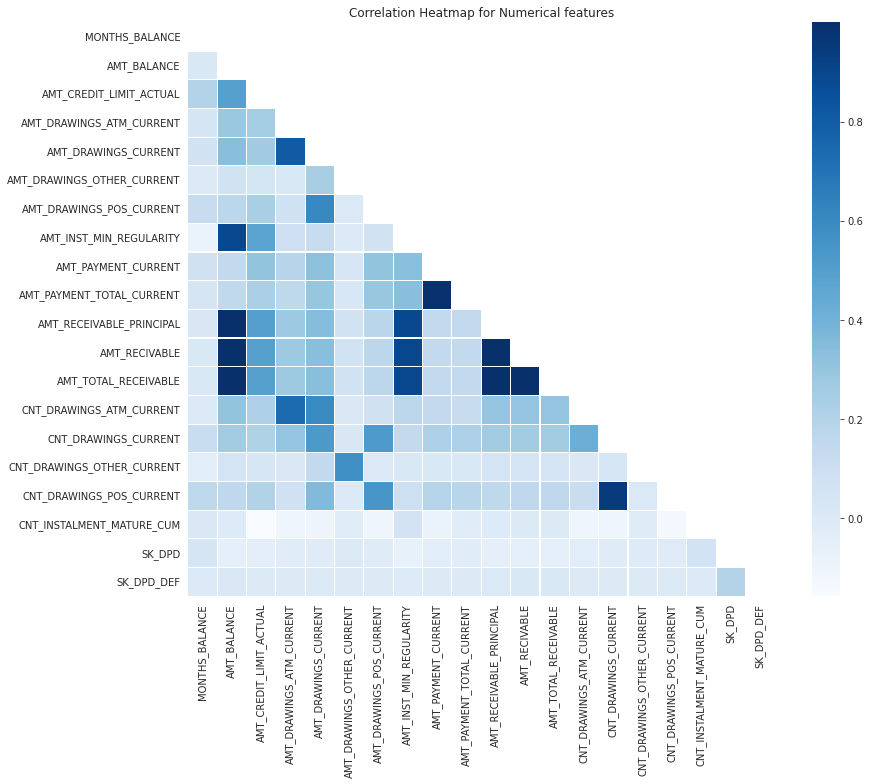

----------------------------------------------------------------------------------------------------


In [23]:
corr_mat = correlation_matrix(credit_card_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

**Comment**
1.   From the heatmap of correlation matrix, we see a few couples of highly correlated features. These are:
 *   AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE and AMT_BALANCE
 *   We also observe high correlation between these 3 AMT_RECEIVABLE columns
 *   AMT_PAYMENT_TOTAL_CURRENT and AMT_PAYMENT_CURRENT
2. The sets of 2nd and 3rd correlating features are understandable because they more or less the same tale.
3. The correlation of features with Target isn't noticeable, this shows the absence of a linear relationship between the feature and the target variable.

**Plotting Continuous Variables**

Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [28]:
credit_card_balance_merged = credit_card_balance_merged.groupby('SK_ID_PREV').mean()

In [31]:
credit_card_balance_merged.head(10)

,SK_ID_CURR,TARGET,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
1000018.0,394447.0,0.0,-4.0,74946.281250,81000.000000,5400.000000,29478.996094,0.0,24078.996094,2594.087891,...,72298.195312,73602.585938,73602.585938,1.200195,8.800000,0.0,7.601562,2.000000,0.000000,0.0
1000030.0,361282.0,0.0,-4.5,55991.062500,81562.500000,642.857117,17257.437500,0.0,19079.929688,2078.223633,...,55474.453125,55935.375000,55935.375000,0.142822,5.125000,0.0,5.714844,1.875000,0.000000,0.0
1000035.0,436351.0,0.0,-4.0,0.000000,225000.000000,NaN,0.000000,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.0
1000077.0,181153.0,0.0,-7.0,0.000000,94090.909091,NaN,0.000000,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.0
1000083.0,309691.0,0.0,-7.0,0.000000,183461.538462,NaN,0.000000,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.0
1000087.0,399664.0,0.0,-16.5,39078.105469,71718.750000,3483.870850,4278.475098,0.0,932.619202,2242.807373,...,37748.398438,39085.410156,39085.410156,0.225830,0.406250,0.0,0.193604,9.164062,0.000000,0.0
1000089.0,161517.0,0.0,-3.0,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.0
1000096.0,306118.0,0.0,-48.5,38598.312500,180000.000000,3539.062500,4334.960938,0.0,795.898621,2743.612061,...,36996.453125,38567.324219,38567.324219,0.177124,0.260417,0.0,0.083313,34.562500,0.354167,0.0
1000123.0,387909.0,0.0,-5.5,0.000000,163125.000000,0.000000,27842.535156,0.0,31694.947266,1270.687500,...,0.000000,0.000000,0.000000,0.000000,5.875000,0.0,6.714844,1.250000,0.000000,0.0


#### **AMT_BALANCE**

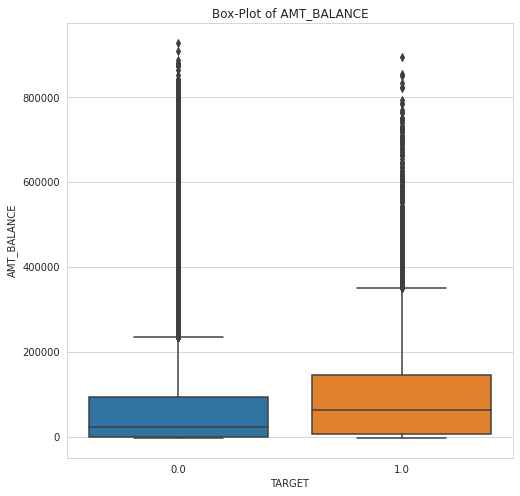

In [29]:
plot_continuous_variables(credit_card_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

**Comment**
1.   From the above plot, it can be seen that the Defaulters have a higher value of AMT_BALANCE as compared to Non-Defaulters. They show a higher values of all the quantiles and even the whiskers. This could imply that the Credit amount for Defaulters could also be relatively higher as compared to Non-Defaulters.
2.   We see that the Defaulters here too appeared to have a higher minimum installment each month as compared to Non-Defaulters. This usually tells about the spending and borrowing habbit of the people. The defaulters show a higher spending and borrowing habits as compared to Non-Defaulters.




#### **AMT_TOTAL_RECEIVABLE**


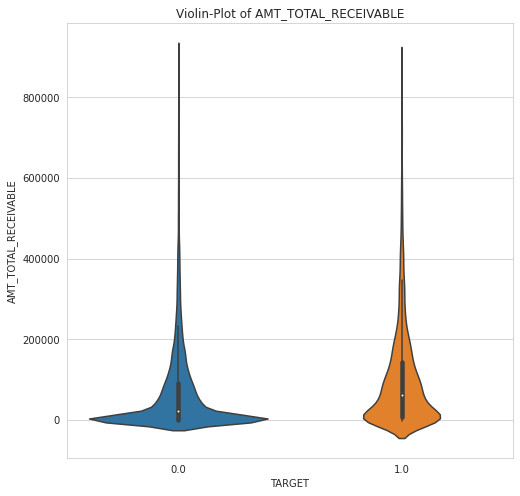

In [30]:
plot_continuous_variables(credit_card_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (8,8))

**Comment**

Looking at the box plot of AMT_TOTAL_RECEIVABLE, we see a similar behavious as seen with other amounts as well, which is that the Defaulters usually had higher Amount Receivable on their previous credit, which may imply the higher amounts of credits that they may have taken. The PDF also shows a very higher peak at lower amounts for Non-Defaulters as compared to Defaulters.

**CNT_INSTALMENT_MATURE_CUM**

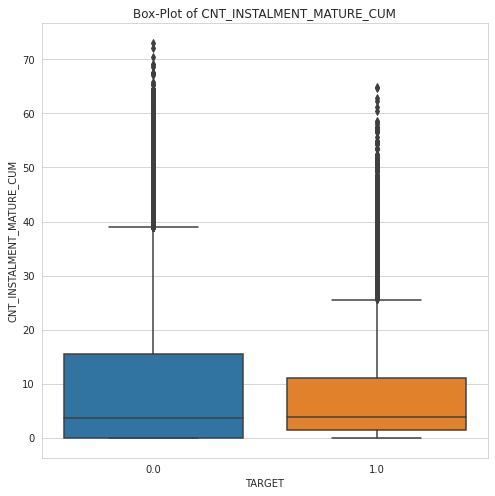

In [32]:
plot_continuous_variables(credit_card_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))

**Comment**

From the above plot, we see a very interesting behaviour. This plot shows that the Non-Defaulters usually had higher range of values for the number of installments paid as compared to Defaulters. This might show the defaulting behaviour, where in the defaulters usually would pay fewer number of installments on their previous credit.

####**Drop**

In [38]:
credit_card_balance_droped = credit_card_balance[['SK_ID_PREV','SK_ID_CURR','MONTHS_BALANCE','AMT_BALANCE','AMT_CREDIT_LIMIT_ACTUAL','AMT_DRAWINGS_CURRENT','AMT_INST_MIN_REGULARITY','AMT_RECEIVABLE_PRINCIPAL','AMT_RECIVABLE','AMT_TOTAL_RECEIVABLE','CNT_DRAWINGS_CURRENT','CNT_INSTALMENT_MATURE_CUM','NAME_CONTRACT_STATUS']].copy()

In [40]:
credit_card_balance_droped.shape

(3840312, 13)

In [41]:
credit_card_balance_droped.to_csv('/content/drive/MyDrive/Colab/credit_card_balance_droped.csv')